# Conv1D

In [1]:
skip_training = False  # Set this flag to True before validation and submission

In [2]:
# During evaluation, this cell sets skip_training to True

import tools, warnings
warnings.showwarning = tools.customwarn

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
# When running on your own computer, you can specify the data directory by:
# data_dir = tools.select_data_dir('/your/local/data/directory')
data_dir = tools.select_data_dir()

output_dir = tools.select_data_dir(/output)

The data directory is ../data


In [5]:
# Select device which you are going to use for training
device = torch.device("cuda:0")
# device = torch.device("cpu")

In [6]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device("cpu")

## Data

In [18]:
from data import MotusDataset_best_of, plot_dataset_sample

cutoff = 1 # length of IR
resample_rate = None

trainset = MotusDataset_best_of(root=data_dir, train=True, split=0.05, cutoff=cutoff, resample=resample_rate)
trainloader = torch.utils.data.DataLoader(dataset=trainset)
# trainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=1, collate_fn=collate, shuffle=True)

# testset = MotusDataset_best_of(root=data_dir, train=False, cutoff=cutoff, num_tail_samples=num_tail_samples, resample=None)
# testloader = torch.utils.data.DataLoader(dataset=testset)

../data\Motus/best_of/sh_rirs
Dataset with 2 samples. 
Input(channels, time_dim), output(...) shapes: torch.Size([1, 2400]), torch.Size([1, 45600])


Let's visualize the data with some plots, and audio play the head and tail

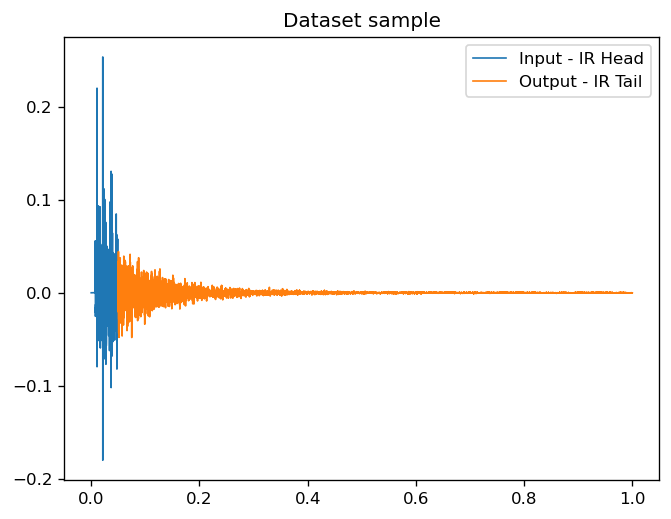

In [9]:
sample_head, sample_tail = plot_dataset_sample(trainset,dpi=120)

In [10]:
from IPython.display import Audio, display

sample_head, sample_tail = trainset[0]
fs = trainset.sample_rate
Audio(torch.cat((sample_head[0], sample_tail[0]), dim=0), rate=fs)

# Architecture

Lightweight model: fully connected layers=6, hidden size=32

* Architecture here:
    * Conv1D (out_chanels=32, kernel_size=4, stride=4) + Leaky ReLU
    * Conv1D (out_chanels=32, kernel_size=2, stride=2) + Leaky ReLU 
    - Conv1D (out_chanels=128, kernel_size=2, stride=2) + Leaky ReLU 
    - Conv1D (out_chanels=128, kernel_size=2, stride=2) + Leaky ReLU 
    - Conv1D (out_chanels=128, kernel_size=2, stride=2) + Leaky ReLU 
    - Conv1D (out_chanels=out_channels, kernel_size=2, stride=2) + Leaky ReLU 
    - linear layer (hidden size, hidden size) + Leaky ReLU 
    - linear layer (hidden size, 1)


In [13]:
class IRCNN(nn.Module):
    def __init__(self, in_channels, out_channels, out_dim, negative_slope=0.01):
        super(IRCNN,self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, 32, 4, stride=4),
            nn.Conv1d(32, 32, 2, stride=2),
            nn.Conv1d(32, 128, 8, stride=8),
            nn.Conv1d(128, 128, 2, stride=2),
            nn.Conv1d(128, 512, 2, stride=2),
            nn.Conv1d(512, 512, 4, stride=4),
            nn.Conv1d(512, 1024, 2, stride=2),
            nn.Conv1d(1024, 1024, 1, stride=1),
            nn.Flatten(),
        )
        self.fcn1 = nn.LazyLinear(512)
        self.fcn2 = nn.Linear(512, out_dim, bias=False)
        
    def forward(self, x):
        """
        Args:
            x of shape (batch_size*IR_len, input_mapped_dim = 4*2*10 = 80): 
            Tensor with transformed input position vectors.
        Returns:
            out of shape (batch_size, 1): value for time step t            
        """
        out = self.conv(x)
#         print(out.shape)
        out = self.fcn1(out)
#         out= self.nl1(out)
        out = self.fcn2(out)
#         out = self.nl2(out)
#         out = self.fcn3(out)
#         print(out.shape)
        
        return out

In [14]:
def test_IRCNN_shapes():
    x = torch.randn(2, 2, 2400)
    channels = x.shape[1]
    out_dim = 64
    model = IRCNN(channels, channels, out_dim)
    out = model(x)

test_IRCNN_shapes()

In [43]:
###### Plotting model output every 500 epochs ######
time1 = np.linspace(0,sample_head.shape[-1]/fs, sample_head.shape[-1])
time2 = np.linspace(time1[-1], sample_tail.shape[-1]/fs+time1[-1], sample_tail.shape[-1])
def plot_model_output(model, dataset, epoch, criterion=None, idx=0, plot=True, xlim=None, ylim=None, save_file=False, filename=None):
    with torch.no_grad():
        model.eval()
        x, y = dataset[idx]
        x = x[None,:,:].to(device).float()
        y = y[None,:,:].to(device).float()
        y_pred = model(x)
        if criterion!= None:
            loss = criterion(y_pred,y)
            print(f"Loss: {loss.item()}")
        
        x_ = torch.flatten(x.cpu())
        y_ = torch.flatten(y.cpu())
        y_pred_ = torch.flatten(y_pred.cpu())
        
        #Plot the data 
        if plot:
            fig, ax = plt.subplots(1)
            ax.plot(time2, y_, linewidth=1)
            ax.plot(time2, y_pred_, ':', linewidth=1)
            ax.set_title(f'Prediction for Epoch {epoch+1}')
            ax.legend(['GT - tail','Predicted - tail'])
            plt.xlabel('Time')
            plt.ylabel('Pressure Amplitude')
        
        if xlim!=None: # xlim in seconds w.r.t entire IR
            plt.xlim(xlim)
        if ylim!=None:
            plt.ylim(ylim)
        if save_file:
            plt.savefig(filename, bbox_inches="tight")

        return x_, y_, y_pred_
    
# x, y, y_pred = plot_model_output(cnn_model, trainset, epoch, criterion=criterion, xlim=[0.995,1], ylim=[-0.0005, 0.0005])

### Training
Initialize the IR-CNN model, then train.

In [28]:
sample_head, sample_tail = trainset[0]
channels = sample_head.shape[0]
out_dim = sample_tail.shape[-1]
cnn_model = IRCNN(channels, channels, out_dim).to(device)
print(cnn_model)

IRCNN(
  (conv): Sequential(
    (0): Conv1d(1, 32, kernel_size=(4,), stride=(4,))
    (1): Conv1d(32, 32, kernel_size=(2,), stride=(2,))
    (2): Conv1d(32, 128, kernel_size=(8,), stride=(8,))
    (3): Conv1d(128, 128, kernel_size=(2,), stride=(2,))
    (4): Conv1d(128, 512, kernel_size=(2,), stride=(2,))
    (5): Conv1d(512, 512, kernel_size=(4,), stride=(4,))
    (6): Conv1d(512, 1024, kernel_size=(2,), stride=(2,))
    (7): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,))
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (fcn1): LazyLinear(in_features=0, out_features=512, bias=True)
  (fcn2): Linear(in_features=512, out_features=45600, bias=False)
)


In [46]:
from torchinfo import summary

summary(cnn_model)

Layer (type:depth-idx)                   Param #
IRCNN                                    --
├─Sequential: 1-1                        --
│    └─Conv1d: 2-1                       160
│    └─Conv1d: 2-2                       2,080
│    └─Conv1d: 2-3                       32,896
│    └─Conv1d: 2-4                       32,896
│    └─Conv1d: 2-5                       131,584
│    └─Conv1d: 2-6                       1,049,088
│    └─Conv1d: 2-7                       1,049,600
│    └─Conv1d: 2-8                       1,049,600
│    └─Flatten: 2-9                      --
├─Linear: 1-2                            524,800
├─Linear: 1-3                            23,347,200
Total params: 27,219,904
Trainable params: 27,219,904
Non-trainable params: 0

Epoch 50100. Loss: 1.3606241736852098e-05
Epoch 50200. Loss: 1.3524351288651815e-05
Epoch 50300. Loss: 1.3405896879703505e-05
Epoch 50400. Loss: 1.4485557585430797e-05
Epoch 50500. Loss: 1.3858963484381093e-05
Epoch 50600. Loss: 1.4032917988515692e-05
Epoch 50700. Loss: 1.3831121123075718e-05
Epoch 50800. Loss: 1.3547183698392473e-05
Epoch 50900. Loss: 1.3277212474349653e-05
Epoch 51000. Loss: 1.537528942208155e-05
Epoch 51100. Loss: 1.3368626241572201e-05
Epoch 51200. Loss: 1.382353502776823e-05
Epoch 51300. Loss: 1.4599653695768211e-05
Epoch 51400. Loss: 1.2981920008314773e-05
Epoch 51500. Loss: 1.3751797268923838e-05
Epoch 51600. Loss: 1.134785998146981e-05
Epoch 51700. Loss: 1.166742686109501e-05
Epoch 51800. Loss: 1.1567459296202287e-05
Epoch 51900. Loss: 1.2166759006504435e-05
Epoch 52000. Loss: 1.2882704140793066e-05
Epoch 52100. Loss: 1.1608728073042585e-05
Epoch 52200. Loss: 1.3148346624802798e-05
Epoch 52300. Loss: 1.292810566155822e-05
Epoch 52400. Loss: 1.3267831491248216e-

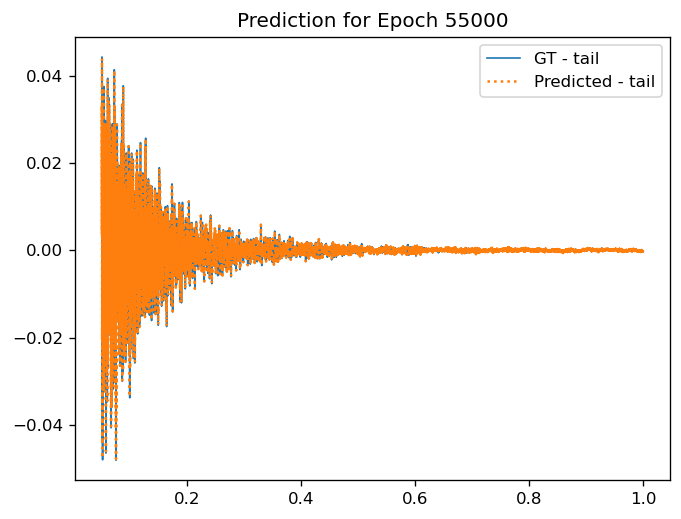

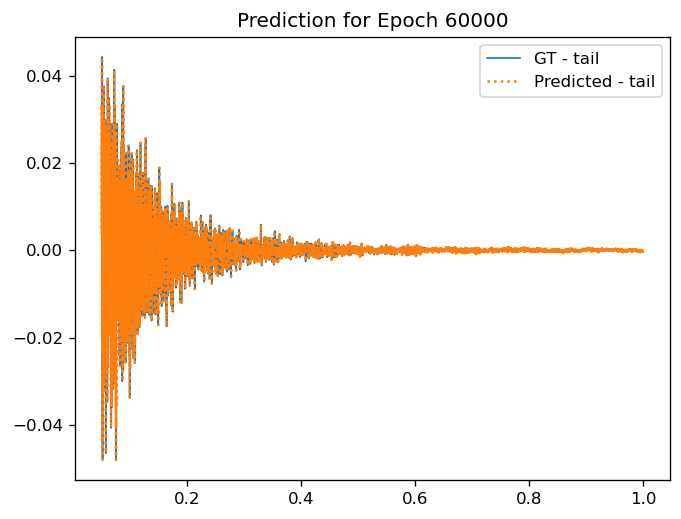

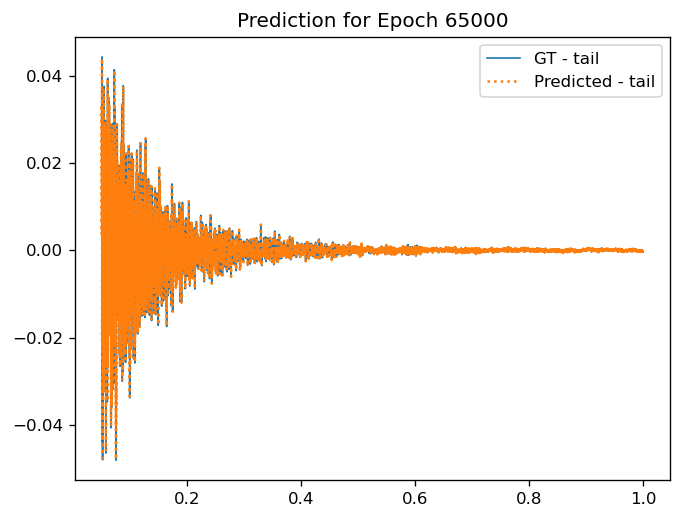

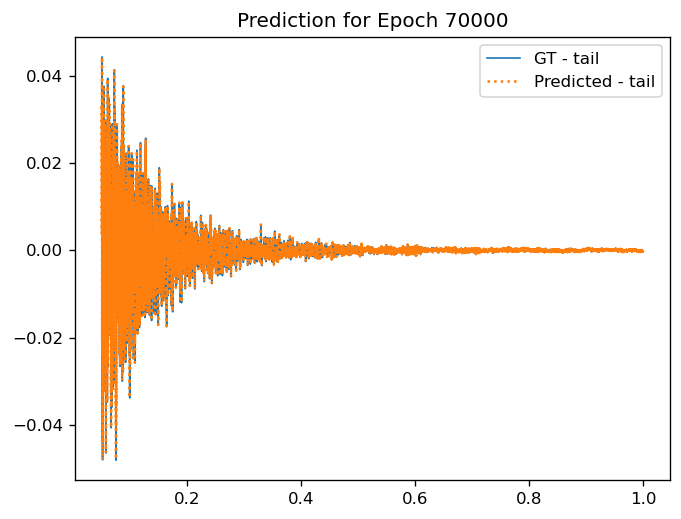

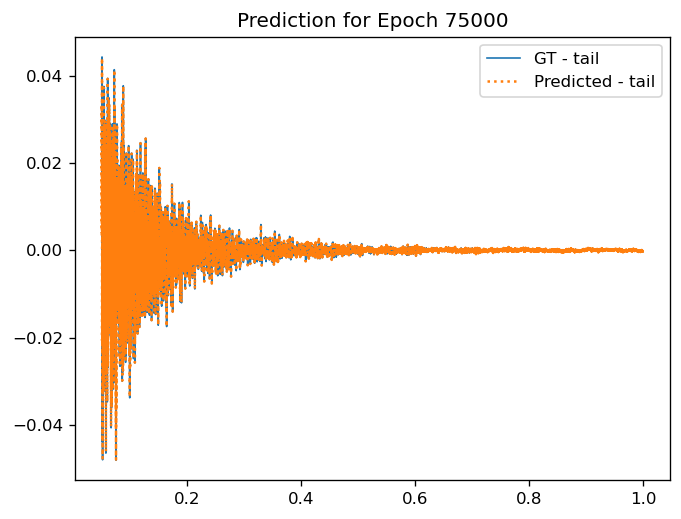

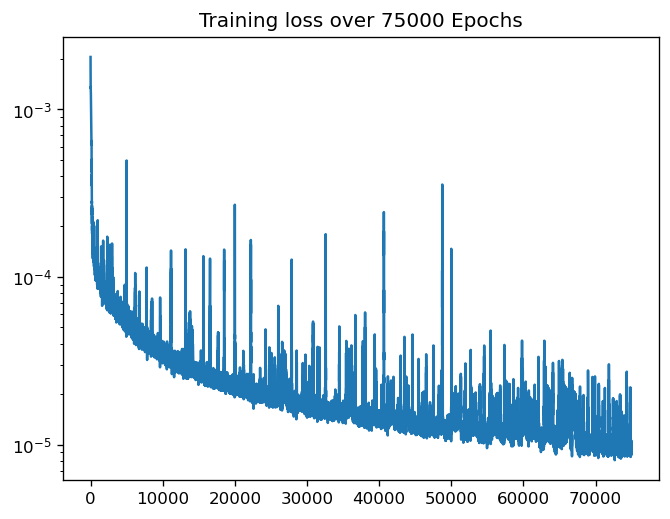

In [32]:
###### Training #######
model_name = "CNN1d_L1"
if not skip_training:
    EPOCHS = 75000
    optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.0001)
    criterion = nn.L1Loss()
#     loss_over_time = []

    for epoch in range(50000, EPOCHS):
        cnn_model.train()
        total_loss = 0
        for x, y in trainloader:
            x = x.to(device).float()
            y = y.to(device).float()
            out = cnn_model(x)
            
            # Zero gradient of optimizer:
            optimizer.zero_grad()
            loss = criterion(out, y.view(y.shape[0], -1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        loss_over_time.append(total_loss/len(trainloader))
        
        if epoch==0 or epoch==9 or epoch==49 or epoch==99 or epoch==199 or epoch%500 == 499:
            print(f"Epoch {epoch+1}. Loss: {total_loss/len(trainloader)}")
        if epoch == 9 or epoch%5000==4999:
            x, y, y_pred = plot_model_output(cnn_model, trainset, epoch, 
                              criterion=criterion, 
                              save_file=True, 
                              filename=model_name + "_epoch" + str(epoch+1).zfill(5) + "_pred.png")

    # save and plot training loss
    np.save(model_name+"_train_loss", loss_over_time)
    
    fig, ax = plt.subplots(1)
    ax.plot(loss_over_time[5:])
    ax.set_yscale('log')
    ax.set_title(f'Training loss over {EPOCHS} Epochs')
    plt.savefig(model_name + "_train_loss.png", bbox_inches="tight")
    plt.show()

In [33]:
if not skip_training:
    tools.save_model(cnn_model, model_name+'.pth', confirm=True)

Do you want to save the model (type yes to confirm)?  yes


Model saved to CNN1d_L1.pth.


### Evaluation

Plot model prediction, play GT and predicted audio

Loss: 1.0790587111841887e-05


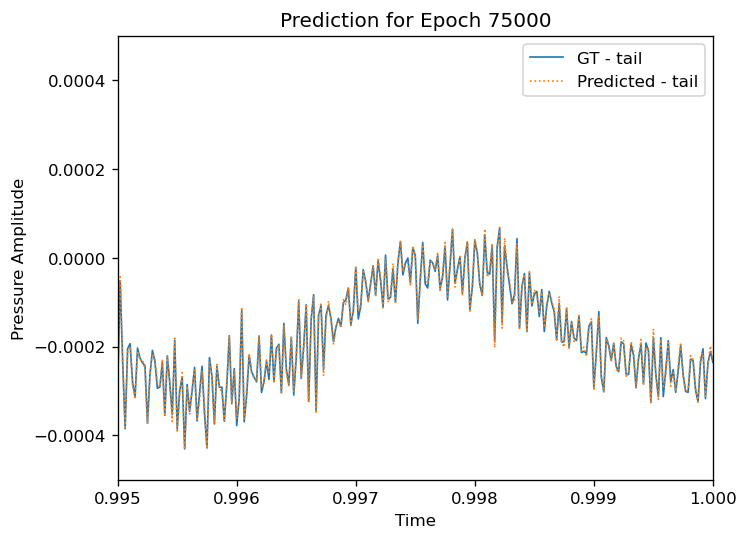

In [67]:
x, y, y_pred = plot_model_output(cnn_model, trainset, epoch, criterion=criterion, xlim=[0.995,1], ylim=[-0.0005, 0.0005])

Loss: 1.0790587111841887e-05


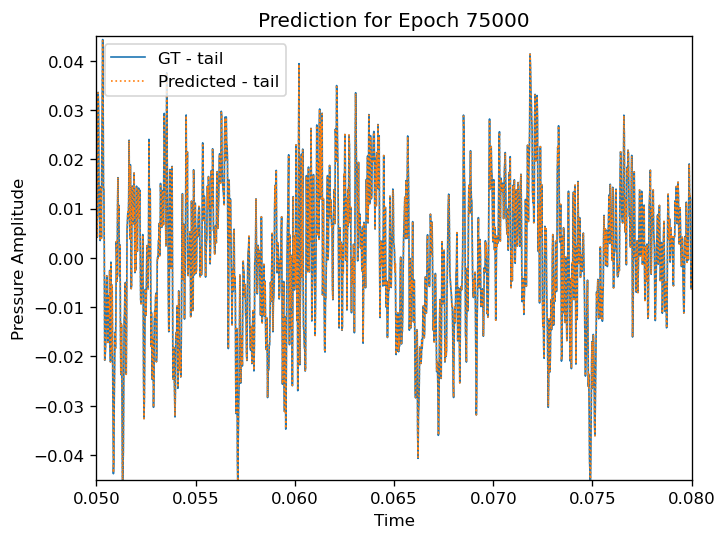

In [68]:
x, y, y_pred = plot_model_output(cnn_model, trainset, epoch, criterion=criterion, xlim=[0.05,0.08], ylim=[-0.045, 0.045])

In [48]:
# Play GT IR
Audio(torch.cat((x,y)), rate=fs)

In [49]:
# Play predicted IR
Audio(torch.cat((x,y_pred)), rate=fs)

[[[ 0.0324882   0.01361145  0.00418298 ... -0.00023703 -0.00021118
   -0.00023566]
  [ 0.03240827  0.01358761  0.00416134 ... -0.00023998 -0.00019826
   -0.00023103]]

 [[ 0.00566401  0.00251826 -0.0022837  ...  0.00011329  0.00013199
    0.00019578]
  [ 0.00569267  0.00251495 -0.00227423 ...  0.00010157  0.00013807
    0.00020585]]]


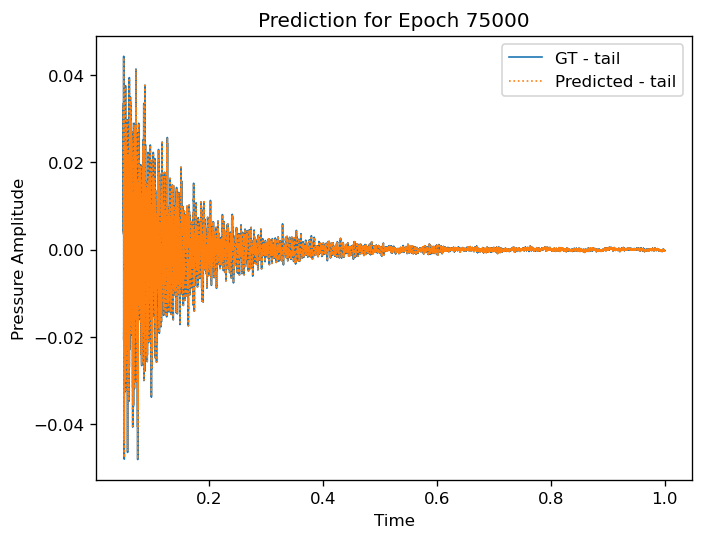

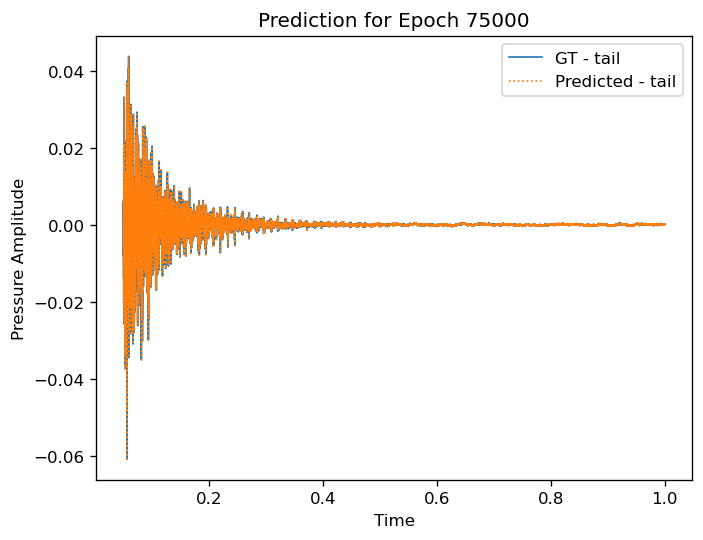

In [59]:
model_outputs = np.empty((len(trainset),2,len(sample_tail[0])))

for i in range(len(trainset)):
    _, y, y_pred = plot_model_output(cnn_model, 
                                     trainset, 
                                     epoch, 
                                     idx=i)
    model_outputs[i,0,:] = y
    model_outputs[i,1,:] = y_pred
print(model_outputs)

In [66]:
np.save("./output/"+model_name+"_gt_prediction1", model_outputs)

In [65]:
"./output/"+model_name+"_gt_prediction"

'./output/CNN1d_L1_gt_prediction'

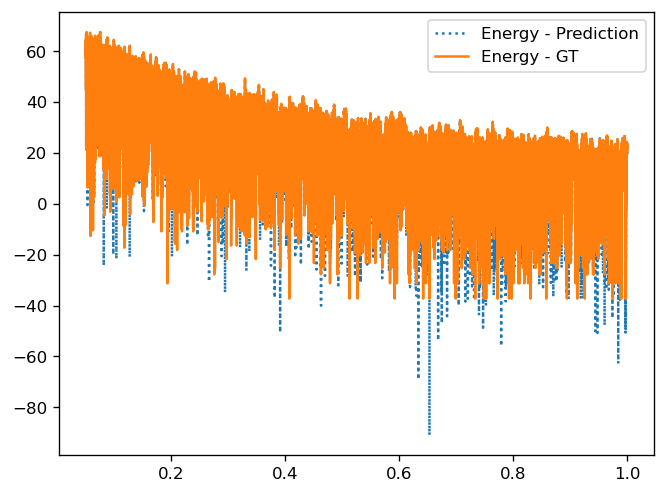

In [52]:
# Energy decay graph
with torch.no_grad():
#     cnn_model.eval()
#     x, y = trainset[0]
#     x = x[None,:,:].to(device).float()
#     y = y[None,:,:].cpu().float()
#     y_pred = cnn_model(x)
    
    pa_ref = 2e-5
    gt_energy = 10*torch.log10((torch.flatten(y)/pa_ref)**2)
    pred_energy = 10*torch.log10((torch.flatten(y_pred.cpu())/pa_ref)**2)
    fig, ax = plt.subplots(1)    
    ax.plot(time2, pred_energy, ':')
    ax.plot(time2, gt_energy)
    ax.legend(['Energy - Prediction', 'Energy - GT'])
    plt.show()

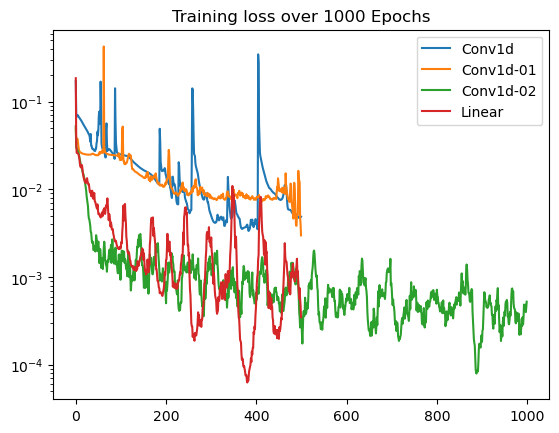

In [117]:
# Training loss across models
fig, ax = plt.subplots(1)  
ax.plot(loss_over_time)
ax.plot(loss_over_time01)
ax.plot(loss_over_time02)
ax.plot(loss_over_time_mlp)
ax.legend(['Conv1d','Conv1d-01', 'Conv1d-02','Linear'])
ax.set_yscale('log')
ax.set_title(f'Training loss over {EPOCHS} Epochs')
plt.savefig("cnn_cnn01_cnn02_mlp_training_loss.png", bbox_inches="tight")
plt.show()